# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [35]:
# Installed the required libraries      
!pip install prophet

In [36]:
# Imported the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np                                                          
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [37]:
# Stored the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index
df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True,
).dropna()

# Reviewed the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

C:\Users\Garzo\AppData\Local\Temp\ipykernel_45132\3612204697.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [38]:
# Reviewed the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


In [39]:
# Looked into the columns of the 'df_mercado_trends' dataframe for better context
df_mercado_trends.columns

Index(['Search Trends'], dtype='object')

<Axes: xlabel='Date'>

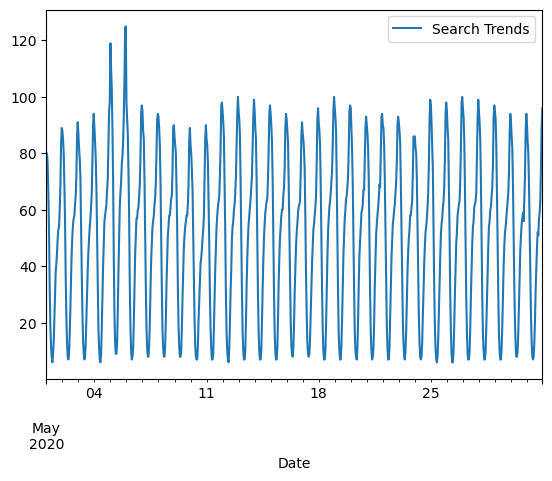

In [40]:
# Sliced the DataFrame to include only data for May 2020
df_may_2020 = df_mercado_trends.loc['2020-05']

# Plotted to visualize the data for May 2020
df_may_2020.plot(label='Search Trends')

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [41]:
# Calculated the sum of the total search traffic for May 2020
total_search_traffic_may_2020 = df_may_2020['Search Trends'].sum()

# Viewed the traffic_may_2020 value
print("Total search traffic for May 2020:", total_search_traffic_may_2020)

Total search traffic for May 2020: 38181


In [42]:
# Calcluated the monhtly median search traffic across all months
# Grouped the DataFrame by index year and then index month, chain the sum and then the median functions
monthly_median_traffic = (
    df_mercado_trends
    .groupby([df_mercado_trends.index.year, df_mercado_trends.index.month])['Search Trends']
    .sum()
    .median()
)

# Viewed the 'median_monthly_traffic' value
print("Monthly median search traffic across all months:", monthly_median_traffic)

Monthly median search traffic across all months: 35172.5


In [43]:
# Divided the May traffic total by the median monthly traffic
ratio = (total_search_traffic_may_2020 / monthly_median_traffic).round(6)

# Displayed the results
print("Ratio of total search traffic for May 2020 to monthly median search traffic:", ratio)

Ratio of total search traffic for May 2020 to monthly median search traffic: 1.085536


##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** According to the May 2020 search trend graph, the search traffic for MercadoLibre increased on the 5th and 6th of May, most likely due to the release of their financial reports. Since the ratio for the May search traffic was 1.0855, the search traffic increased by 8.6%. This is outside of a margin of a nominal 5% increase/decrease, so the search traffic for May increased by a significant enough value.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

<Axes: xlabel='Hour of Day (24h/Day)', ylabel='Average Hourly Traffic'>

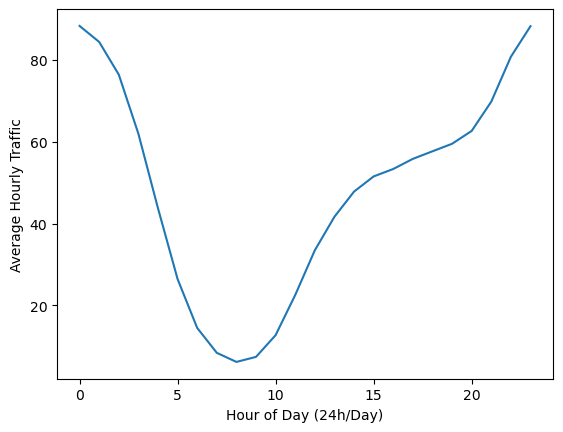

In [44]:
# Groupd the hourly search data to plot the average traffic by the day of week
average_traffic_by_hour = df_mercado_trends.groupby(df_mercado_trends.index.hour)['Search Trends'].mean()

# Plotted the graph using .plot(), added in simple labeling for betrter context
average_traffic_by_hour.plot(xlabel='Hour of Day (24h/Day)', ylabel='Average Hourly Traffic')

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

<Axes: xlabel='Week Day (Sunday=0)', ylabel='Average Daily Traffic'>

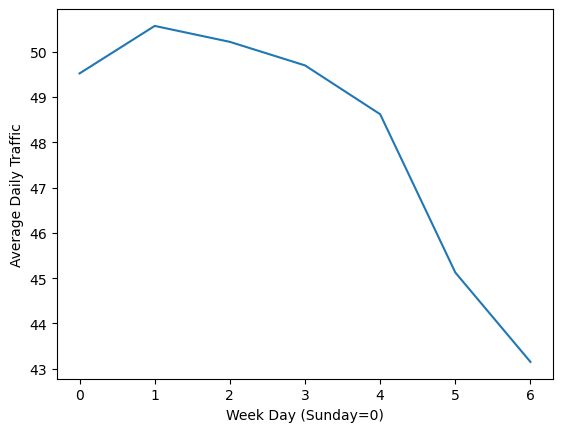

In [45]:
# Grouped the hourly search data to plot the average traffic by the day of week
average_traffic_by_day = df_mercado_trends.groupby(df_mercado_trends.index.day_of_week)['Search Trends'].mean()

# Plotted the graph using .plot(), added in labels for better context
average_traffic_by_day.plot(xlabel='Week Day (Sunday=0)', ylabel='Average Daily Traffic')

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

<Axes: xlabel='Week of Year (52w/Year)', ylabel='Average Traffic'>

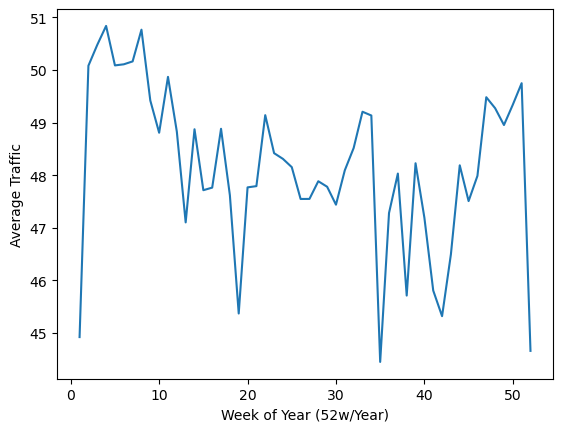

In [46]:
# Grouped the hourly search data to plot the average traffic by the week of the year (woy)
# 'weekofyear' is being depreciated, so I used .isocalenar().week instead
average_traffic_by_woy = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week)['Search Trends'].mean()

# Plotted the graph using .plot(), added labels for better context
average_traffic_by_woy.plot(xlabel='Week of Year (52w/Year)', ylabel='Average Traffic')

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:**
From the hourly graph, it looks as though the main traffic times are early morning and late evening of the day. Given that people are generally at work or school during a business day, it would make sense that search traffic takes place outside working hours.

From the daily graph, it appears that the trend in traffic days is Sunday to Thursday, with the apex at Sunday/Monday midnight. My guess is that people in Latin America generally do their online shopping on Sundays going into the early week. From Thursday to Saturday, there is a noticeable drop in traffic, probably because they are spending Friday and Saturday away from the computer and enjoying family time or other endeavors.

From the weekly graph, I'm seeing Q1 as the biggest traffic quarter. My guess is people are grabbing the post-holiday sales or window shopping for items they didn't get during the holidays. Another noticeable increase happens a little after week 40, which marks the start of the holiday buying season, up to the end of the year where there is a noticeable decrease in traffic happening around week 51 going into week 1 of the following year.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [47]:
# Uploaded the "mercado_stock_price.csv" file into the cell, then stored in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True,
).dropna()

# Viewed the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


In [48]:
# Looking into the columns of the 'df_mercado_stock' dataframe for better context
df_mercado_stock.columns

Index(['close'], dtype='object')

<Axes: xlabel='date'>

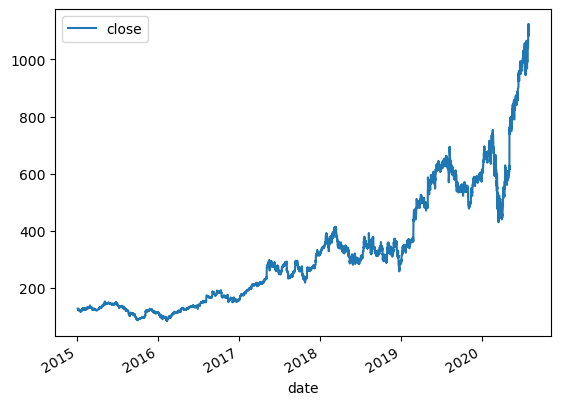

In [49]:
# Visualized the closing price of the df_mercado_stock DataFrame using .plot() 
df_mercado_stock.plot()

In [50]:
# Concatenated the 'df_mercado_stock' DataFrame with the 'df_mercado_trends' DataFrame
# Concatenated the DataFrame by columns (axis=1), and dropped rows with only one column of data
concatenated_df = pd.concat([df_mercado_stock, df_mercado_trends], axis=1)

# Dropped rows with only one column of data by making 'thresh=2' the threshold for not dropping rows
concatenated_df = concatenated_df.dropna(thresh=2)

# Viewed the first and last five rows of the DataFrame
display(concatenated_df.head())
display(concatenated_df.tail())

,close,Search Trends
2016-06-01 09:00:00,135.16,6.0
2016-06-01 10:00:00,136.63,12.0
2016-06-01 11:00:00,136.56,22.0
2016-06-01 12:00:00,136.42,33.0
2016-06-01 13:00:00,136.10,40.0


,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [51]:
# For the combined dataframe, I sliced the first half of 2020, (2020-01 through 2020-06)
df_first_half_2020 = concatenated_df['2020-01':'2020-06']

# Viewed the first and last five rows of first_half_2020 DataFrame
display(df_first_half_2020.head())
display(df_first_half_2020.tail())

,close,Search Trends
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0


,close,Search Trends
2020-06-30 11:00:00,976.17,17.0
2020-06-30 12:00:00,977.50,27.0
2020-06-30 13:00:00,973.23,37.0
2020-06-30 14:00:00,976.50,45.0
2020-06-30 15:00:00,984.93,51.0


array([<Axes: >, <Axes: >], dtype=object)

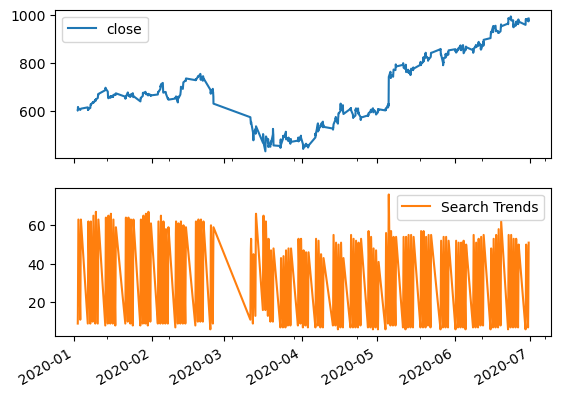

In [52]:
# Visualized the 'close' and 'search trends' data by plotting each column
# on a separate axis using the following syntax: 'plot(subplots=True)'
concatenated_df['2020-01':'2020-06'].plot(subplots=True)

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** 
The data suggests a potential correlation between search activity and stock prices for Mercado Libre, with observations such as reduced search activity coinciding with a stock price low point and spikes in both search traffic and stock price around earnings release dates. While these instances hint at a possible relationship, the analysis acknowledges the limited evidence of a consistent trend. Further time-series research would be necessary to ascertain whether both time series exhibit a common trend consistently aligned with this narrative.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [53]:
# Created a new column in the 'mercado_stock_trends_df' DataFrame called 'Lagged Search Trends' 
# This column shifts the 'Search Trends' information by one hour
concatenated_df['Lagged Search Trends'] = concatenated_df['Search Trends'].shift(1)


In [54]:
# Created a new column in the 'mercado_stock_trends_df' DataFrame called 'Stock Volatility'
# This column calculates the standard deviation of the closing stock price return data over a 4 period rolling window
concatenated_df['Stock Volatility'] = concatenated_df['close'].pct_change().rolling(window=4).std()


<Axes: >

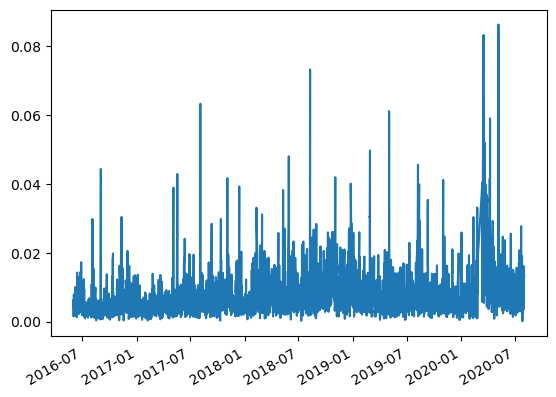

In [55]:
# Visualized the stock volatility
concatenated_df['Stock Volatility'].plot()

**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [56]:
# Created a new column in the 'mercado_stock_trends_df' DataFrame called 'Hourly Stock Return'
# This column calculates the hourly return percentage of the closing price
concatenated_df['Hourly Stock Return'] = concatenated_df['close'].pct_change() * 100


In [57]:
# Viewed the first and last five rows of the 'mercado_stock_trends_df' DataFrame
display(concatenated_df.head())
display(concatenated_df.tail())

,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN,1.087600
2016-06-01 11:00:00,136.56,22.0,12.0,NaN,-0.051233
2016-06-01 12:00:00,136.42,33.0,22.0,NaN,-0.102519
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134,-0.234570


,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20.0,11.0,0.012837,0.637986
2020-07-31 12:00:00,1087.925,32.0,20.0,0.013549,-1.614697
2020-07-31 13:00:00,1095.800,41.0,32.0,0.013295,0.723855
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013001,1.355174
2020-07-31 15:00:00,1122.510,53.0,47.0,0.013566,1.067843


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [58]:
# Constructed a correlation table of 'Stock Volatility,' 'Lagged Search Trends,' and 'Hourly Stock Return'
# to find any possible correlations among the data
correlation_table = concatenated_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

# Displayed correlation table 
display(correlation_table)

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** 
The analysis suggests a nuanced relationship between search activity and stock market variables. It notes a slight negative correlation between searches for a firm and subsequent stock volatility, indicating that increased search activity may correspond to slightly lower near-term hourly stock risk. Conversely, there's a weak positive correlation between search activity in one hour and stock returns in the next, albeit very weak with a correlation close to zero. Some argue that this suggests almost no relationship between these variables, and any observed findings could be due to chance. Overall, while correlations exist, they tend to be weak, underscoring the complexity of predicting market movements solely based on search activity. This underscores the importance of considering additional factors that influence stock market behavior.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [59]:
# Created a new DataFrame: 'df_mercado_trends_b' by resting the previous DataFrame
df_mercado_trends_b = df_mercado_trends.reset_index()

# Labeled the columns 'ds' and 'y' so that the syntax is recognized by Prophet
df_mercado_trends_b = df_mercado_trends_b.rename(columns={'Date': 'ds', 'Search Trends': 'y'})

# Dropped 'NaN' values from the DataFrame
df_mercado_trends_b.dropna(inplace=True)

# Viewed the first and last five rows of the DataFrame
display(df_mercado_trends_b.head())
display(df_mercado_trends_b.tail())

,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [60]:
# Called the Prophet function and stored it as an object
prophet_model = Prophet()

# Displayed Prophet function information
display(prophet_model)

In [61]:
# Fit the time-series model.
prophet_model.fit(df_mercado_trends_b)

19:33:32 - cmdstanpy - INFO - Chain [1] start processing
19:33:45 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
# Created a 'future_mercado_trends' dataframe to hold predictions
# Made the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = prophet_model.make_future_dataframe(periods=2000, freq='H')

# Viewed the last five rows of the 'future_mercado_trends' DataFrame
future_mercado_trends.tail()

,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [63]:
# Made the predictions for the trend data using the 'future_mercado_trends' DataFrame and calling it 'forcast'
forecast = prophet_model.predict(future_mercado_trends)

# Displayed the first five rows of the 'forecast_mercado_trends' DataFrame
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.352625,81.492232,97.692780,44.352625,44.352625,45.307367,45.307367,45.307367,41.452720,...,1.860390,1.860390,1.860390,1.994257,1.994257,1.994257,0.0,0.0,0.0,89.659992
1,2016-06-01 01:00:00,44.353557,77.570070,93.929568,44.353557,44.353557,41.753097,41.753097,41.753097,37.943514,...,1.810288,1.810288,1.810288,1.999294,1.999294,1.999294,0.0,0.0,0.0,86.106654
2,2016-06-01 02:00:00,44.354489,67.459479,84.507810,44.354489,44.354489,31.429548,31.429548,31.429548,27.656552,...,1.768695,1.768695,1.768695,2.004301,2.004301,2.004301,0.0,0.0,0.0,75.784037
3,2016-06-01 03:00:00,44.355421,52.076158,69.106838,44.355421,44.355421,16.162280,16.162280,16.162280,12.417302,...,1.735704,1.735704,1.735704,2.009275,2.009275,2.009275,0.0,0.0,0.0,60.517701
4,2016-06-01 04:00:00,44.356353,34.513417,51.609262,44.356353,44.356353,-0.952639,-0.952639,-0.952639,-4.678127,...,1.711270,1.711270,1.711270,2.014218,2.014218,2.014218,0.0,0.0,0.0,43.403713


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

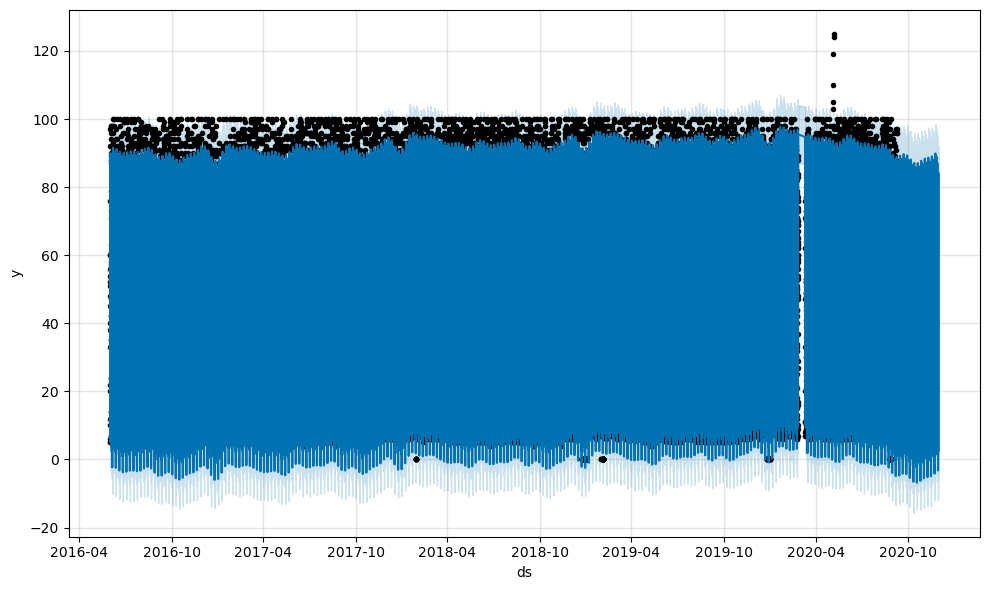

In [64]:
# Plotted the Prophet predictions for the Mercado trends data
fig = prophet_model.plot(forecast)

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** Based on the general data in the previous trend model, the popularity of MercadoLibre is trending downward from the first prediction date, sometime near January/February 2020, to October 2020. From October to the end of the prediction cycle, it looks like the popularity trends back upwards. This could coincide with the beginning of the holiday season.

#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [65]:
# Indexed in the 'forecast' DataFrame to the 'ds' datetime column
forecast.set_index('ds', inplace=True)

# Viewed only the 'yhat' 'yhat_lower' and 'yhat_upper' columns from the DataFrame
forecast[['yhat', 'yhat_lower', 'yhat_upper']].head()


,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.659992,81.492232,97.692780
2016-06-01 01:00:00,86.106654,77.570070,93.929568
2016-06-01 02:00:00,75.784037,67.459479,84.507810
2016-06-01 03:00:00,60.517701,52.076158,69.106838
2016-06-01 04:00:00,43.403713,34.513417,51.609262


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

In [66]:
# Viewing the last 5 entrys for better context
forecast[['yhat', 'yhat_lower', 'yhat_upper']].tail()

,yhat,yhat_lower,yhat_upper
ds,,,
2020-11-30 04:00:00,39.507473,31.245131,47.911113
2020-11-30 05:00:00,24.036286,15.797750,32.893775
2020-11-30 06:00:00,12.070566,4.144453,20.945941
2020-11-30 07:00:00,4.798365,-3.653207,13.315354
2020-11-30 08:00:00,2.603438,-5.527054,11.088601


<Axes: xlabel='ds'>

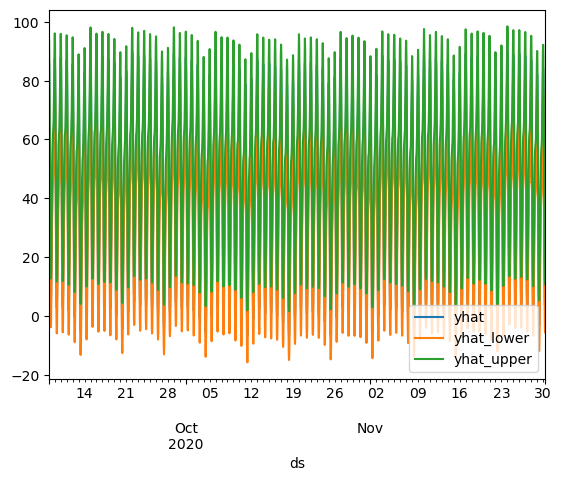

In [67]:
# From the forecast_mercado_trends DataFrame, plotted the data to visualize
# the 'yhat', 'yhat_lower', and 'yhat_upper' columns over the last 2000 hours
forecast[['yhat', 'yhat_lower', 'yhat_upper']].tail(2000).plot()

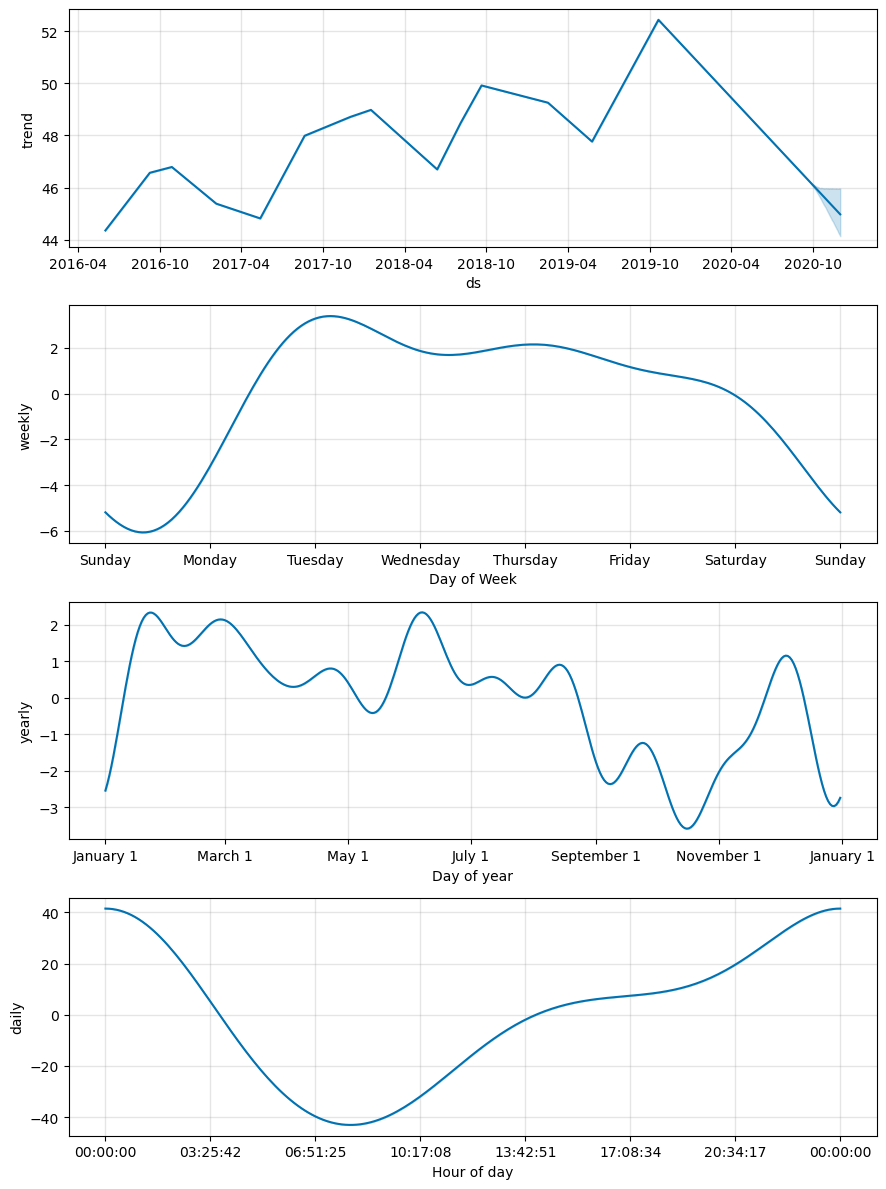

In [68]:
# Reset the index in the 'forecast_mercado_trends' DataFrame
forecast.reset_index(inplace=True)

# Used the 'plot_components' function to visualize the forecast results
# for the 'forecast' DataFrame 
figures = prophet_model.plot_components(forecast)


##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** The most popular times of any given day are roughly from 8:30 PM to about 3:30 AM. I visually used '20' from the 'daily' y-axis as the threshold to develop the time range.

**Question:** Which day of week gets the most search traffic?
   
**Answer:** According to the 'Weekly' chart, the most popular day of the week is Tuesday.

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** According to the 'yearly' column, the lowest point in the calendar year falls somewhere in the middle of October.
